In [ ]:
import pandas as pd
import numpy as np
df = pd.read_excel("S:/Pizza/Pizza_Sale.xlsx")
df.shape

(48620, 12)

In [19]:
df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [3]:
df.dtypes

pizza_id               int64
order_id               int64
pizza_name_id         object
quantity               int64
order_date            object
order_time            object
unit_price           float64
total_price          float64
pizza_size            object
pizza_category        object
pizza_ingredients     object
pizza_name            object
dtype: object

In [23]:
df['order_date'] = pd.to_datetime(df['order_date'],format='%d-%m-%Y')

In [21]:
df.dtypes

pizza_id                      int64
order_id                      int64
pizza_name_id                object
quantity                      int64
order_date           datetime64[ns]
order_time                   object
unit_price                  float64
total_price                 float64
pizza_size                   object
pizza_category               object
pizza_ingredients            object
pizza_name                   object
dtype: object

In [24]:
daily_sales_df = df.groupby(['order_date','pizza_name_id','pizza_category']).agg({'quantity':'sum'}).reset_index()
daily_sales_df

,order_date,pizza_name_id,pizza_category,quantity
0,2015-01-01,bbq_ckn_l,Chicken,6
1,2015-01-01,bbq_ckn_m,Chicken,4
2,2015-01-01,bbq_ckn_s,Chicken,1
3,2015-01-01,big_meat_s,Classic,5
4,2015-01-01,calabrese_m,Supreme,1
...,...,...,...,...
22947,2015-12-31,the_greek_l,Classic,1
22948,2015-12-31,the_greek_xl,Classic,1
22949,2015-12-31,veggie_veg_l,Veggie,4
22950,2015-12-31,veggie_veg_m,Veggie,2


In [25]:
prophet_data = daily_sales_df.groupby(['order_date']).agg({'quantity':'sum'}).reset_index()
prophet_data

,order_date,quantity
0,2015-01-01,156
1,2015-01-02,191
2,2015-01-03,99
3,2015-01-04,135
4,2015-01-05,154
...,...,...
353,2015-12-27,89
354,2015-12-28,102
355,2015-12-29,80
356,2015-12-30,82


In [26]:
prophet_data.columns = ['ds', 'y']

In [43]:
daily_sales_df['Year'] = daily_sales_df['order_date'].dt.year
daily_sales_df['Month'] = daily_sales_df['order_date'].dt.month
daily_sales_df['Day'] = daily_sales_df['order_date'].dt.day

In [44]:
daily_sales_df['Hour'] = daily_sales_df['order_date'].dt.hour
daily_sales_df['Minute'] = daily_sales_df['order_date'].dt.minute
daily_sales_df['Second'] = daily_sales_df['order_date'].dt.second
daily_sales_df.head(3)

,order_date,pizza_name_id,pizza_category,quantity,Hour,Minute,Second,Year,Month,Day
0,2015-01-01,bbq_ckn_l,Chicken,6,0,0,0,2015,1,1
1,2015-01-01,bbq_ckn_m,Chicken,4,0,0,0,2015,1,1
2,2015-01-01,bbq_ckn_s,Chicken,1,0,0,0,2015,1,1


In [45]:
daily_sales_df.set_index('order_date',inplace=True)

In [46]:
df = daily_sales_df.copy()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()

In [56]:
df = df.reset_index()

In [57]:
df.order_date.min()

Timestamp('2015-01-01 00:00:00')

In [58]:
df.order_date.max()

Timestamp('2015-12-31 00:00:00')

In [59]:
df.set_index('order_date',inplace=True)

In [60]:
train = df.loc[df.index < '2015-09-01']
test = df.loc[df.index >= '2015-09-01']

In [61]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=30,gap = 1)
df = df.sort_index()

In [63]:
def create_feature(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    #df['weekofmonth'] = df.index.weekofmonth
    return df

df = create_feature(df)
    

In [64]:
def add_lags(df):
    target_map = df['quantity'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('90 days')).map(target_map)
    return df

df = add_lags(df)

In [65]:
df.sample(3)

,pizza_name_id,pizza_category,quantity,Hour,Minute,Second,Year,Month,Day,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
order_date,,,,,,,,,,,,,,,,,,,,
2015-06-24,prsc_argla_m,Supreme,3,0,0,0,2015,6,24,0,2,2,6,2015,175,24,26,1.0,3.0,1.0
2015-07-29,bbq_ckn_s,Chicken,1,0,0,0,2015,7,29,0,2,3,7,2015,210,29,31,2.0,2.0,3.0
2015-01-16,bbq_ckn_m,Chicken,3,0,0,0,2015,1,16,0,4,1,1,2015,16,16,3,NaN,NaN,NaN


In [77]:
from sklearn.preprocessing import LabelEncoder

df['pizza_name_id'] = LabelEncoder().fit_transform(df['pizza_name_id'])

In [78]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'pizza_name_id'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=400,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:50.50977


s:\Pizza\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:30.52866
[200]	validation_0-rmse:26.73657
[300]	validation_0-rmse:26.18483
[399]	validation_0-rmse:26.10888


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

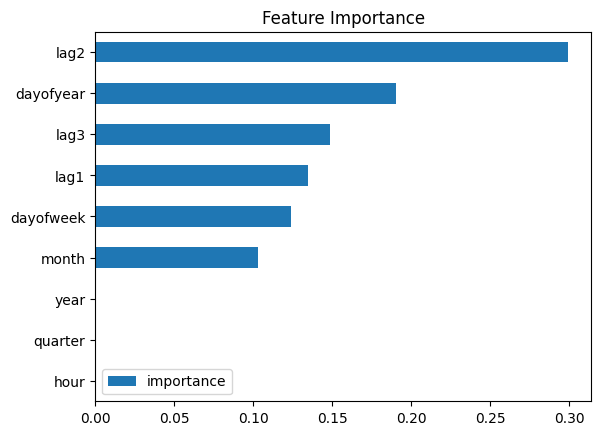

In [79]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [80]:
# Create future dataframe
future = pd.date_range('2016-01-01','2016-03-30', freq='D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_feature(df_and_future)
df_and_future = add_lags(df_and_future)

In [81]:
future_w_features = df_and_future.query('isFuture').copy()

In [82]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

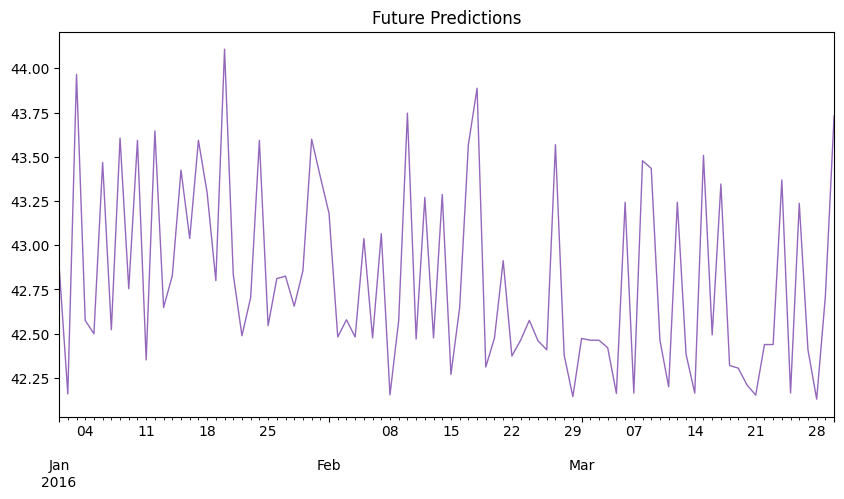

In [83]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [73]:
future_w_features.pred.sum()

np.float32(191.24365)

In [84]:
future_w_features= future_w_features[['pred']]
future_w_features.reset_index(inplace=True)

In [85]:
future_w_features

,index,pred
0,2016-01-01,42.885239
1,2016-01-02,42.160172
2,2016-01-03,43.965652
3,2016-01-04,42.574913
4,2016-01-05,42.499908
...,...,...
85,2016-03-26,43.237015
86,2016-03-27,42.408672
87,2016-03-28,42.130211
88,2016-03-29,42.712944


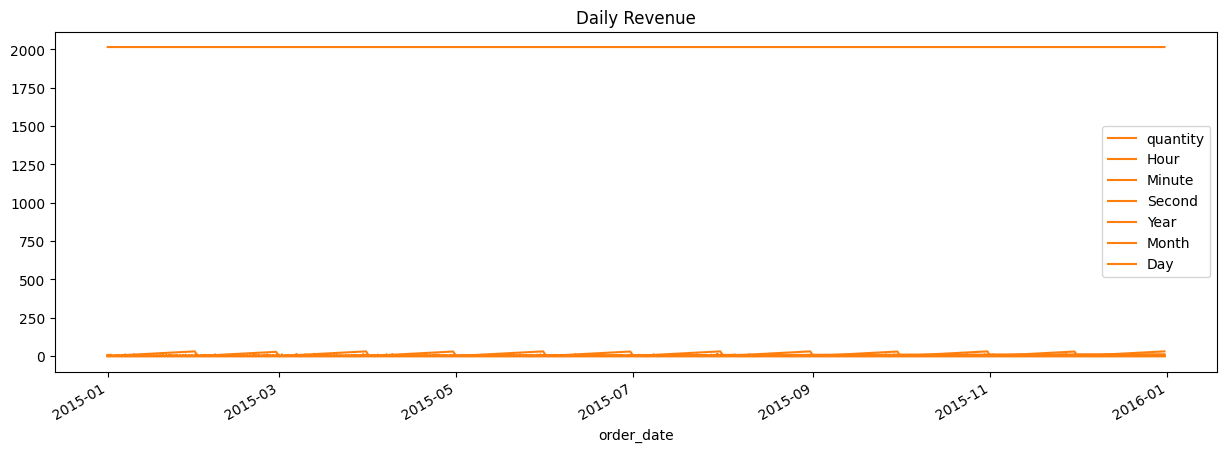

In [48]:
df.plot(style = '-',figsize = (15,5),
        color = color_pal[1],
        title = "Daily Revenue")
plt.show()

In [8]:
df['pizza_ingredients']

0                 Sliced Ham, Pineapple, Mozzarella Cheese
1        Pepperoni, Mushrooms, Red Onions, Red Peppers,...
2        Mozzarella Cheese, Provolone Cheese, Smoked Go...
3        Calabrese Salami, Capocollo, Tomatoes, Red Oni...
4        Tomatoes, Red Peppers, Jalapeno Peppers, Red O...
                               ...                        
48615    Chicken, Red Onions, Red Peppers, Mushrooms, A...
48616    Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...
48617    Tomatoes, Anchovies, Green Olives, Red Onions,...
48618    Tomatoes, Red Peppers, Jalapeno Peppers, Red O...
48619    Barbecued Chicken, Red Peppers, Green Peppers,...
Name: pizza_ingredients, Length: 48620, dtype: object

In [9]:
ingredients =  df['pizza_ingredients'].str.split(",", expand=True)
num_ingredients = ingredients.shape[1]
ingredients.columns = [f'ingredient{i+1}' for i in range(num_ingredients)]
df = pd.concat([df, ingredients], axis=1)
df

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,...,Minute,Second,ingredient1,ingredient2,ingredient3,ingredient4,ingredient5,ingredient6,ingredient7,ingredient8
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,...,0,0,Sliced Ham,Pineapple,Mozzarella Cheese,None,None,None,None,None
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,...,0,0,Pepperoni,Mushrooms,Red Onions,Red Peppers,Bacon,None,None,None
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,...,0,0,Mozzarella Cheese,Provolone Cheese,Smoked Gouda Cheese,Romano Cheese,Blue Cheese,Garlic,None,None
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,...,0,0,Calabrese Salami,Capocollo,Tomatoes,Red Onions,Green Olives,Garlic,None,None
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,...,0,0,Tomatoes,Red Peppers,Jalapeno Peppers,Red Onions,Cilantro,Corn,Chipotle Sauce,Garlic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48615,48616,21348,ckn_alfredo_m,1,2015-12-31,21:23:10,16.75,16.75,M,Chicken,...,0,0,Chicken,Red Onions,Red Peppers,Mushrooms,Asiago Cheese,Alfredo Sauce,None,None
48616,48617,21348,four_cheese_l,1,2015-12-31,21:23:10,17.95,17.95,L,Veggie,...,0,0,Ricotta Cheese,Gorgonzola Piccante Cheese,Mozzarella Cheese,Parmigiano Reggiano Cheese,Garlic,None,None,None
48617,48618,21348,napolitana_s,1,2015-12-31,21:23:10,12.00,12.00,S,Classic,...,0,0,Tomatoes,Anchovies,Green Olives,Red Onions,Garlic,None,None,None
48618,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,...,0,0,Tomatoes,Red Peppers,Jalapeno Peppers,Red Onions,Cilantro,Corn,Chipotle Sauce,Garlic


In [15]:
df.dtypes

pizza_id                      int64
order_id                      int64
pizza_name_id                object
quantity                      int64
order_date           datetime64[ns]
order_time                   object
unit_price                  float64
total_price                 float64
pizza_size                   object
pizza_category               object
pizza_ingredients            object
pizza_name                   object
Year                          int32
Month                         int32
Day                           int32
Hour                          int32
Minute                        int32
Second                        int32
ingredient_1                 object
ingredient_2                 object
ingredient_3                 object
ingredient_4                 object
ingredient_5                 object
ingredient_6                 object
ingredient_7                 object
ingredient_8                 object
dtype: object

In [11]:
date_df = df[['order_date','total_price','Year','Month','Day','Hour','Minute','Second','quantity']]
date_df.set_index('order_date',inplace=True)
date_df.total_price.head()

order_date
2015-01-01    13.25
2015-01-01    16.00
2015-01-01    18.50
2015-01-01    20.75
2015-01-01    16.00
Name: total_price, dtype: float64

In [9]:
df.total_price.describe

<bound method NDFrame.describe of order_date
2015-01-01    13.25
2015-01-01    16.00
2015-01-01    18.50
2015-01-01    20.75
2015-01-01    16.00
              ...  
2015-12-31    16.75
2015-12-31    17.95
2015-12-31    12.00
2015-12-31    20.25
2015-12-31    12.75
Name: total_price, Length: 48620, dtype: float64>